In [4]:
!pip install xgboost

In [6]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 10.4 MB/s eta 0:00:00


In [8]:
!pip install hyperopt

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 7.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.8 MB/s eta 0:00:00


In [10]:
!pip install tsfresh

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   --------- ------------------------------ 2.4/9.8 MB 11.1 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.8 MB 10.0 MB/s eta 0:00:01
   --------------------------- ------------ 6.8/9.8 MB 10.6 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.8 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------- ----------------- 2.4/4.2 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------------------------- ------ 2.4/2.8 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   --- ------------------------

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
import re
import glob
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.preprocessing import StandardScaler

from collections import defaultdict
from datetime import datetime
from tsfresh import extract_features as ts_extract_features
from tsfresh.feature_selection.selection import select_features

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from sklearn.base import clone
from copy import deepcopy

color = sns.color_palette()

In [79]:

_VISUALIZE_PATIENT = os.path.join(_DATASET_ROOT_PATH, "activity_data", "patient_activity_57.csv")
#57번 환자의 활동 데이터를 시각화 대상

In [80]:
_RANDOM_SEED = 0            #Kfold 수행 시 동일한 결과를 얻기 위한 고정된 시드값 지정
_NUMBER_OF_FOLDS = 10       #10-Fold교차 검증 사용
_NUMBER_OF_FEATURES = 20    #feature 20개 사용 
_TEST_RATIO = .30           #전체 데이터 중 30% test, 70% train

In [81]:
#하이퍼파라미터 설정 딕셔너리
_PARAMS_LORGREG = {
    "penalty": "l2", "C": 1.0, "class_weight": "balanced",
    "random_state": 0, "solver": "liblinear", "n_jobs": 1
}

_PARAMS_RFC = {
    "n_estimators": 1000, "criterion": "entropy",
    "max_features": "auto", "max_depth": None,
    "min_samples_split": 2, "min_samples_leaf": 1,
    "min_weight_fraction_leaf": 0.0,
    "max_leaf_nodes": None, "bootstrap": True,
    "oob_score": False, "n_jobs": -1, "random_state": _RANDOM_SEED,
    "class_weight": "balanced"
}

_PARAMS_XGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    'objective':'binary:logistic', "learning_rate": .01
}

_PARAMS_LIGHTGB = {
    "n_estimators": 1000, "random_state": _RANDOM_SEED, "verbosity": 0,
    "objective": "binary", "learning_rate": .01
}

#이진 분류 / 클래스 불균형에 대한 대처 / 학습률을 낮게 설정해서 느리지만 안정적인 학습 추구
#모델 훈련 반복 수(1000)많음 / random_state로 결과 재현성을 확보

In [82]:
def k_fold_model_evaluation( model_func, model_parameters, fit_parameters={}, n_splits=_NUMBER_OF_FOLDS, shuffle=True, random_state=_RANDOM_SEED ):
                    #모델 생성 함수 / 하이퍼파라미터(딕셔너리) / fit 전달 추가 인자 / 분할 수 10개 / 데이터 셔플 여부 / 시드값 
    y_preds, y_trues = [], []

    k_fold = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state)
    #클래스 비율을 유지하면서 데이터를 나누는 방식. shuffle=True라 무작위로 섞은 뒤 fold를 나눔
    
    models = [ ]
    k_fold_results = [ ]

    for train_index, fold_index in k_fold.split(np.zeros(len(X_TRAIN)), Y_TRAIN.ravel()):
        
        model = model_func(**model_parameters)
        #전달된 모델 생성 함수와 파라미터로 모델 인스턴스 생성
        x_fold_train, x_fold_test = X_TRAIN.iloc[train_index], X_TRAIN.iloc[fold_index]
        y_fold_train, y_fold_test = Y_TRAIN.iloc[train_index], Y_TRAIN.iloc[fold_index]
        #KFold에서 받은 index를 이용하여 train / test 분할
        model = model.fit( x_fold_train, y_fold_train, **fit_parameters )
        models.append( deepcopy(model) )
        #fold의 학습 데이터를 이용하여 학습 후 .append()모델 저장
        y_pred = model.predict_proba( x_fold_test )[:, 1]
                                                #클래스 1의 확률
        k_fold_results.append((list(y_pred), list(y_fold_test)))
        #예측 결과와 실제값을 tuple로 저장
    return models, np.array(k_fold_results)
    #각 fold에서 훈련된 모델들 리스트와 예측 확률 및 실제값을 담은 배열을 반환하라

In [83]:
def cv_confusion_matrix(k_fold_results, average=True):   #KFold 전체 혼동 행렬 계산 후 평균 여부 선택 가능한 함수. True = 혼동 행렬 반환 False=누적 총합 반환
    cm = np.zeros((2,2))     #혼동 행렬 초기화 2x2
    for fold_index, (y_pred, y_true) in enumerate(k_fold_results):
        y_pred = np.round(y_pred)
        #확률 = 반올림하라
        cm += metrics.confusion_matrix(y_true, y_pred)   #혼동 행렬 계산
    if average:
        return cm / len(k_fold_results)
    return cm

In [84]:
def calculate_cv_results(cv_results):    #결과로부터 성능 지표 계산하고 보기 좋게 정리해줌
    cv_metrics = defaultdict(list)       #cv_result = k_fold_model_evaluation()이 반환한 k_fold_result
    for fold_index, fold_results in enumerate(cv_results):  #각 fold 결과에서 예측값, 실제값 분리
        y_preds, y_trues = fold_results
        y_preds = np.round(np.array(y_preds, dtype=np.float32))    # 예측 확률 0 또는 1로 라운딩
        cv_metrics["Fold"].append("Fold %i" % fold_index)
        cv_metrics["Accuracy"].append(metrics.accuracy_score(y_trues, y_preds))   #전체 중 맞춘 비율
        cv_metrics["Precision"].append(metrics.precision_score(y_trues, y_preds, average="binary"))  #Positive 예측한 것 중 정답 비율
        cv_metrics["Recall"].append(metrics.recall_score(y_trues, y_preds, average="binary"))     #실제 Positive 중 예측 성공 비율 
        cv_metrics["F1-Score"].append(metrics.f1_score(y_trues, y_preds, average="binary"))     #Precision과 Recall의 조화 평균
        cv_metrics["MCC"].append(metrics.matthews_corrcoef(y_trues, y_preds))             #클래스 불균형에 강한 성능 지표 [-1,1]범위
    return pd.DataFrame(data=dict(cv_metrics))   #수집한 결과들을 df로 변환해서 반환

In [85]:
#각 fold의 예측 결과(y_pred, y_true)로부터 ROC , PR Curve /성능을 평균내어 전체적인 분류 품질을 시각화하는 함수
def plot_au_curves(k_fold_results):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    precision = dict()
    recall = dict()
    average_precision = dict()

    all_preds = []
    all_trues = []

    for i, (y_pred, y_true) in enumerate(k_fold_results):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, y_pred)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_true, y_pred)
        average_precision[i] = metrics.average_precision_score(y_true, y_pred)
        all_preds.extend(y_pred)
        all_trues.extend(y_true)
    #개별 fold ROC, PR 계산 + 전체 리스트 저장
    
    fpr["mean"], tpr["mean"], _ = metrics.roc_curve(all_trues, all_preds)
    roc_auc['mean'] = metrics.auc(fpr['mean'], tpr['mean'])
    precision["mean"], recall["mean"], _ = metrics.precision_recall_curve(all_trues, all_preds)
    average_precision['mean'] = metrics.average_precision_score(all_trues, all_preds)
    #전체 fold 통합한 평균 ROC & PR 곡선 계산

    fig = plt.figure(figsize=(18,6))

    # auroc : 모형이 얼마나 잘 구분했는지
    ax1 = fig.add_subplot(121)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
            label='Chance', alpha=.8)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # for i in range(len(k_fold_results)):
    #     ax1.plot(fpr[i], tpr[i], color=colors[i],
    #         label=r'ROC Fold %i (AUC = %0.2f)' % (i+1,roc_auc[i]),
    #         lw=3, alpha=.5)

    ax1.plot(fpr['mean'], tpr['mean'], color='b',
            label=r'Mean ROC (AUC = %0.2f)' % (roc_auc['mean']),
            lw=4, alpha=.8)    

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Receiver Operating Characteristic Curve", size=20)
    plt.xlabel('False Positive Rate',size=20); plt.xticks(size=15)
    plt.ylabel('True Positive Rate',size=20); plt.yticks(size=15)
    ax1.legend(loc="lower right",prop={"size":15})

    # auprc : positive class가 희귀할 때 유용하게 쓰임
    ax2 = fig.add_subplot(122)

    # for i in range(len(k_fold_results)):
    #     ax2.step(recall[i], precision[i], where='post', color=colors[i],
    #              label=r'AP Fold %i (AP = %0.2f)' % (i+1,average_precision[i]),
    #              lw=3, alpha=.5)

    ax2.step(recall['mean'], precision['mean'], where='post', color='b',
            label=r'Mean AP (AP = %0.2f)' % (average_precision['mean']),
            lw=4, alpha=.8)    

    ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    # plt.title("Precision Recall Curve", size=20)
    plt.xlabel('Recall',size=20); plt.xticks(size=15)
    plt.ylabel('Precision',size=20); plt.yticks(size=15)
    ax2.legend(loc="lower left",prop={"size":15})
    
    
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax1_figure.png', bbox_inches=bbox)
    
    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bbox = extent.expanded(1.3, 1.3)
    bbox.x1 *= 0.95
    fig.savefig('ax2_figure_expanded.png', bbox_inches=bbox)
    #savefig로 각각 ROC , PR 곡선을 이미지로 저장
    
    plt.show()

- dataX 읽어오기

In [86]:
features_path = "./adata/features.csv"

dataX = pd.read_csv(features_path, sep=';')
print(dataX.head())

   ID  ACC__variance_larger_than_standard_deviation  ACC__has_duplicate_max  \
0   1                                           1.0                     0.0   
1   2                                           1.0                     1.0   
2   3                                           1.0                     0.0   
3   5                                           1.0                     0.0   
4   7                                           1.0                     0.0   

   ACC__has_duplicate_min  ACC__has_duplicate  ACC__sum_values  \
0                     1.0                 1.0         433530.0   
1                     1.0                 1.0        1572295.0   
2                     1.0                 1.0        5232087.0   
3                     1.0                 1.0         508325.0   
4                     1.0                 1.0         641357.0   

   ACC__abs_energy  ACC__mean_abs_change  ACC__mean_change  \
0     1.228179e+08             34.574870          0.006254   
1   

In [87]:
dataX = pd.read_csv(features_path, sep=';', header=None)  # 헤더 없이 읽기
dataX.columns = dataX.iloc[0]  # 첫 행을 컬럼 이름으로 지정
dataX = dataX[1:].reset_index(drop=True)  # 첫 행 제거하고 인덱스 재정렬
dataX.head()

,ID,ACC__variance_larger_than_standard_deviation,ACC__has_duplicate_max,ACC__has_duplicate_min,ACC__has_duplicate,ACC__sum_values,ACC__abs_energy,ACC__mean_abs_change,ACC__mean_change,ACC__mean_second_derivative_central,...,ACC__permutation_entropy__dimension_5__tau_1,ACC__permutation_entropy__dimension_6__tau_1,ACC__permutation_entropy__dimension_7__tau_1,ACC__query_similarity_count__query_None__threshold_0.0,"ACC__matrix_profile__feature_""min""__threshold_0.98","ACC__matrix_profile__feature_""max""__threshold_0.98","ACC__matrix_profile__feature_""mean""__threshold_0.98","ACC__matrix_profile__feature_""median""__threshold_0.98","ACC__matrix_profile__feature_""25""__threshold_0.98","ACC__matrix_profile__feature_""75""__threshold_0.98"
0,1,1.0,0.0,1.0,1.0,433530.0,122817856.0,34.57486971627099,0.0062536189924724955,-0.015751679406995598,...,3.120897276731803,4.077141189083764,4.880321040727223,NaN,3.4951562920803574,15.586970585837893,11.632053528220005,12.013495855825687,10.744060257302795,13.176178709005566
1,2,1.0,1.0,1.0,1.0,1572295.0,1010897005.0,103.33069427527406,0.0,-0.0027915947619531014,...,3.8830584511482344,5.149343637225899,6.278021304886579,NaN,3.0545839788424725,15.231546211727817,9.369167763352664,9.348223589555602,8.285911316742116,10.38295135364948
2,3,1.0,0.0,1.0,1.0,5232087.0,6869091389.0,251.84594749952097,0.0,-0.049439494107502154,...,4.364521917472846,5.866383836695325,7.260059989633774,NaN,3.9476382135377936,19.595917942265423,13.502456857372504,13.651750087210699,12.254941432696103,14.77895349784141
3,5,1.0,0.0,1.0,1.0,508325.0,101826079.0,46.47776726584674,0.0,-0.0044943820224719105,...,4.096368485481868,5.464033461123516,6.680095098972395,NaN,3.695875435025533,14.341712544714852,11.853373030971856,12.124791033433421,11.190191602668618,12.813455991830407
4,7,1.0,0.0,1.0,1.0,641357.0,154578271.0,34.6756144326303,0.0,-0.015340364333652923,...,3.4152875599981534,4.490762328603042,5.442471436270797,NaN,3.500962017321801,22.090722034374522,14.492646648356379,14.989600844562638,12.924896512693001,16.40391717822898


- dataY 읽어오기

In [88]:
patient_info_path = './adata/patient_info.csv'

dataY = pd.read_csv(patient_info_path, sep=';')
print(dataY.head(80))

    ID  SEX  AGE  ACC  ACC_TIME  ACC_DAYS  HRV  HRV_TIME  HRV_HOURS  CPT_II  \
0    1    0    3    1  16:00:00       6.0    1  11:00:00       21.0       0   
1    2    0    4    1  10:54:00       6.8    0       NaN        NaN       1   
2    3    1    2    1  15:28:00       7.2    1  15:25:00       21.0       1   
3    4    1    3    0       NaN       NaN    1  16:55:00       22.0       1   
4    5    1    1    1  14:24:00       5.9    1  16:00:00       12.0       1   
..  ..  ...  ...  ...       ...       ...  ...       ...        ...     ...   
75  78    1    2    1  10:00:00       6.1    1  10:00:00       21.0       0   
76  79    1    3    1  13:30:00       7.4    1  13:30:00       24.0       1   
77  80    0    2    0       NaN       NaN    1  13:00:00       22.0       1   
78  81    1    3    1  14:13:00       7.8    1  14:20:00       18.0       1   
79  82    1    2    1  15:00:00       6.5    1  15:00:00       18.0       1   

    ...  HADS_D  MED  MED_Antidepr  MED_Moodstab  M

In [89]:
dataY = pd.read_csv(patient_info_path, sep=';', header=None)  # 헤더 없이 읽기
dataY.columns = dataY.iloc[0]  # 첫 행을 컬럼 이름으로 지정
dataY = dataY[1:].reset_index(drop=True)  # 첫 행 제거하고 인덱스 재정렬
dataY.head(50)

,ID,SEX,AGE,ACC,ACC_TIME,ACC_DAYS,HRV,HRV_TIME,HRV_HOURS,CPT_II,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,0,3,1,16:00:00,6,1,11:00:00,21,0,...,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,0,4,1,10:54:00,6.8,0,NaN,NaN,1,...,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1,2,1,15:28:00,7.2,1,15:25:00,21,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4,1,3,0,NaN,NaN,1,16:55:00,22,1,...,6,1,1,NaN,NaN,1,NaN,1,NaN,0
4,5,1,1,1,14:24:00,5.9,1,16:00:00,12,1,...,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,7,0,3,1,14:30:00,8,1,10:20:00,21,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,8,0,2,1,12:00:00,4.3,0,NaN,NaN,1,...,4,1,NaN,NaN,NaN,1,NaN,NaN,NaN,1
7,9,1,1,1,14:05:00,10,1,13:00:00,17,1,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,10,1,3,1,09:46:00,9,0,NaN,NaN,0,...,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,11,1,3,1,12:00:00,7.1,1,12:00:00,24,1,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [90]:
dataY.columns
#컬럼명 확인

Index(['ID', 'SEX', 'AGE', 'ACC', 'ACC_TIME', 'ACC_DAYS', 'HRV', 'HRV_TIME',
       'HRV_HOURS', 'CPT_II', 'ADHD', 'ADD', 'BIPOLAR', 'UNIPOLAR', 'ANXIETY',
       'SUBSTANCE', 'OTHER', 'CT', 'MDQ_POS', 'WURS', 'ASRS', 'MADRS',
       'HADS_A', 'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab',
       'MED_Antipsych', 'MED_Anxiety_Benzo', 'MED_Sleep',
       'MED_Analgesics_Opioids', 'MED_Stimulants', 'filter_$'],
      dtype='object', name=0)

> ID 기준 merge 

In [91]:
# 컬럼 인덱스 이름 제거 (병합 오류 방지)
dataX.columns.name = None
dataY.columns.name = None

# ID 기준 병합
merged = pd.merge(dataX, dataY, on="ID")

# 결과 확인
merged.head(50)

,ID,ACC__variance_larger_than_standard_deviation,ACC__has_duplicate_max,ACC__has_duplicate_min,ACC__has_duplicate,ACC__sum_values,ACC__abs_energy,ACC__mean_abs_change,ACC__mean_change,ACC__mean_second_derivative_central,...,HADS_D,MED,MED_Antidepr,MED_Moodstab,MED_Antipsych,MED_Anxiety_Benzo,MED_Sleep,MED_Analgesics_Opioids,MED_Stimulants,filter_$
0,1,1.0,0.0,1.0,1.0,433530.0,122817856.0,34.57486971627099,0.0062536189924724955,-0.015751679406995598,...,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2,1.0,1.0,1.0,1.0,1572295.0,1010897005.0,103.33069427527406,0.0,-0.0027915947619531014,...,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,3,1.0,0.0,1.0,1.0,5232087.0,6869091389.0,251.84594749952097,0.0,-0.049439494107502154,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,5,1.0,0.0,1.0,1.0,508325.0,101826079.0,46.47776726584674,0.0,-0.0044943820224719105,...,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,7,1.0,0.0,1.0,1.0,641357.0,154578271.0,34.6756144326303,0.0,-0.015340364333652923,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,8,1.0,1.0,1.0,1.0,1114027.0,719229773.0,110.91615008156607,0.0006525285481239804,-0.016071137216511665,...,4,1,NaN,NaN,NaN,1,NaN,NaN,NaN,1
6,9,1.0,0.0,1.0,1.0,983872.0,242580058.0,41.85468477882271,0.0,-0.0006270029260136547,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,101,1.0,0.0,1.0,1.0,2313347.0,1983985223.0,153.3034731046167,0.0,-0.014031557767658583,...,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,104,1.0,0.0,1.0,1.0,3754292.0,3366737920.0,183.75804619462326,0.0,-0.03195115024140869,...,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,105,1.0,1.0,1.0,1.0,2815659.0,3248332815.0,154.8148148148148,0.00043191879926573806,-0.0019438444924406047,...,5,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1


In [92]:
merged.columns

Index(['ID', 'ACC__variance_larger_than_standard_deviation',
       'ACC__has_duplicate_max', 'ACC__has_duplicate_min',
       'ACC__has_duplicate', 'ACC__sum_values', 'ACC__abs_energy',
       'ACC__mean_abs_change', 'ACC__mean_change',
       'ACC__mean_second_derivative_central',
       ...
       'HADS_D', 'MED', 'MED_Antidepr', 'MED_Moodstab', 'MED_Antipsych',
       'MED_Anxiety_Benzo', 'MED_Sleep', 'MED_Analgesics_Opioids',
       'MED_Stimulants', 'filter_$'],
      dtype='object', length=820)

- 시계열 데이터 처리


In [93]:
# 예시 시계열 데이터 (시간 컬럼이 있는 경우)
merged['merged'] = pd.to_datetime(merged['merged'], format='%H:%M:%S')

# 시간을 초로 변환하기
merged['time_in_seconds'] = merged['merged'].dt.hour * 3600 + merged['merged'].dt.minute * 60 + merged['merged'].dt.second

KeyError: 'merged'

> 시각화

C:\Users\user\AppData\Local\Temp\ipykernel_15200\1005427796.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax5 = sns.distplot(dataY['MADRS'], kde=False)
C:\Users\user\AppData\Local\Temp\ipykernel_15200\1005427796.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax5 = sns.distplot(dataY['WURS'], kde=False)


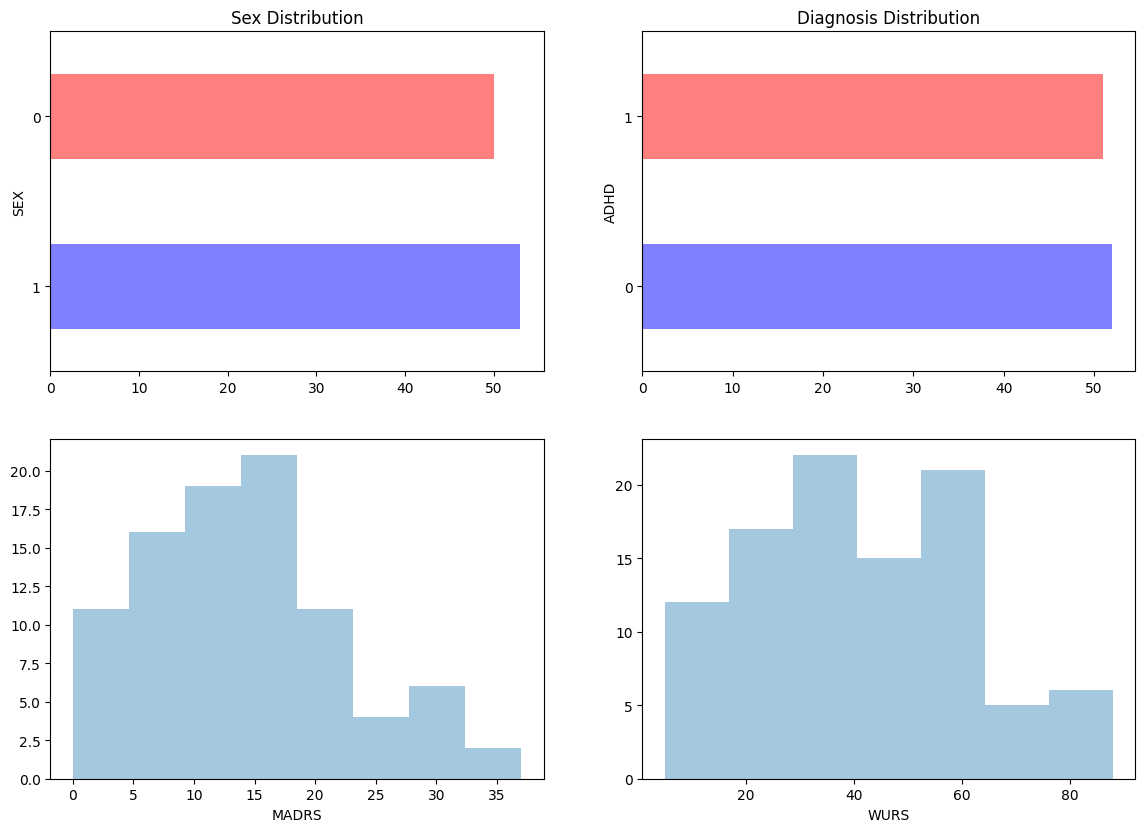

In [54]:
fig = plt.figure(figsize=(14,15))

ax2 = fig.add_subplot(321)
ax2 = dataY['SEX'].value_counts().plot(kind='barh', color=['blue','red'], alpha=.5,
                                                  title='Sex Distribution')
#성별
ax3 = fig.add_subplot(322)
ax3 = dataY['ADHD'].value_counts().plot(kind='barh', color=['blue','red', 'green'], alpha=.5,
                                                  title='Diagnosis Distribution')
#ADHD 진단 여부
ax5 = fig.add_subplot(323)
ax5 = sns.distplot(dataY['MADRS'], kde=False)
#우울증 평가 척도 , 커널밀도추정 표시 x
ax5 = fig.add_subplot(324)
ax5 = sns.distplot(dataY['WURS'], kde=False)
#어린 시절 ADHD증상 / 낮은 점수는 증상없이 높은 점수는 증상 강하게

C:\Users\user\AppData\Local\Temp\ipykernel_15200\1643431303.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  patient_activity_data = pd.read_csv('./adata/patient_activity_57.csv', sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")


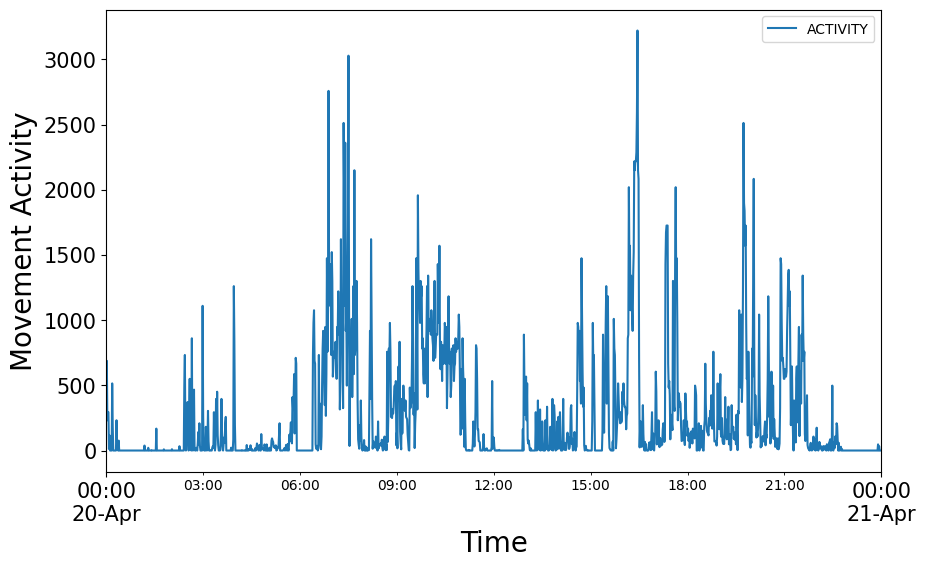

In [57]:
patient_activity_data = pd.read_csv('./adata/patient_activity_57.csv', sep=";", parse_dates=["TIMESTAMP"], infer_datetime_format=True).sort_values(by="TIMESTAMP")
                                                                #컬럼을 날짜 형식으로 파싱/날짜 포맷을 자동으로 추론 후 최적화/시간 순서대로 정렬
patient_activity_data = patient_activity_data.set_index(['TIMESTAMP'])
#TIMESTAMP컬럼을 인덱스로 설정. 시계열 데이터로 쉽게 접근 가능

patient_activity_data.loc['2010-04-20 00:00:00':'2010-04-21 00:00:00'].plot(kind='line', figsize=(10,6))
                         #행 인덱싱에 쓰이는 loc 여기서는 날짜 범위를 지정하여 데이터 필터링                               
plt.xlabel('Time',size=20); plt.xticks(size=15)
plt.ylabel('Movement Activity',size=20); plt.yticks(size=15)

plt.show()

> important features 찾기

In [58]:

dataX = dataX.fillna(0)

# Remove JSON symbols from headers 기호 제거
dataX = dataX.rename(columns = lambda x:re.sub('"', '', x))
dataX = dataX.rename(columns = lambda x:re.sub(',', '', x))
dataY = dataY.rename(columns = lambda x:re.sub('"', '', x))
dataY = dataY.rename(columns = lambda x:re.sub(',', '', x))

# Match X and Y data
dataY = dataY[dataY["ID"].isin(dataX["ID"])]
dataX = dataX[dataX["ID"].isin(dataY["ID"])]

dataY = dataY.set_index("ID")  #ID를 인덱스로 설정, ID가 고유식별자로 사용됨
dataX = dataX.set_index("ID")

dataY = dataY["ADHD"].copy()

# Find relevant features using tsfresh 
#특정 특성들이 목표 변수와 얼마나 관련 있는지 분석하여 유용한 특성만 남기는 과정
dataX = select_features(dataX, dataY)

scaler = StandardScaler(copy=True)    #각 특성의 크기 차이를 없애 모델이 특정 특성에 의존하지 않게 만듦
dataX.loc[:, dataX.columns] = scaler.fit_transform(dataX[dataX.columns])

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(
    dataX,
    dataY,
    test_size=_TEST_RATIO,
    random_state=_RANDOM_SEED,
    stratify=dataY)
#train, test data로 무작위 분할. 전체 데이터에서 20or30%가 test로 사용. 계층적으로 샘플을 분할하는 것까지

C:\Users\user\AppData\Local\Temp\ipykernel_15200\1822913045.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataX = dataX.fillna(0)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''